In [42]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import datasets,models,transforms
from torch import nn
import torch.nn.functional as F
from torch import optim
import os
import sklearn

In [2]:
train_transforms=transforms.Compose([
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                            std=[0.229, 0.224, 0.225])])
test_transforms=transforms.Compose([
                                    transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                            std=[0.229, 0.224, 0.225])])

In [3]:
train_data=datasets.ImageFolder('/content/drive/My Drive/Digits/new train',transform=train_transforms)
val_data=datasets.ImageFolder('/content/drive/My Drive/Digits/new val',transform=test_transforms)
test_data=datasets.ImageFolder('/content/drive/My Drive/Digits/new test',transform=test_transforms)

In [4]:
train_load=torch.utils.data.DataLoader(train_data,batch_size=200,shuffle=True)
val_load=torch.utils.data.DataLoader(val_data,batch_size=200,shuffle=True)
test_load=torch.utils.data.DataLoader(test_data,batch_size=200,shuffle=True)

In [5]:
def save_checkpoint(state,is_best,filepath='/content/drive/My Drive/Digits/resnet18.pth'):
  if is_best:
    print("==> Saving new best")
    torch.save(state,filepath)

In [6]:
def load_checkpoint(checkpoint_fpath,model):
  checkpoint=torch.load(checkpoint_fpath)
  model.load_state_dict(checkpoint['state_dict'])
  return model, checkpoint['epoch'],checkpoint['last']

In [7]:
device='cuda'
new_model=models.resnet18(pretrained=False)

num_labels=7
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    
    self.cnn_layer= torch.nn.Sequential(*(list(new_model.children())[:-1]))
    self.fc=torch.nn.Sequential(nn.Linear(512,24,bias=True),
                                nn.LogSoftmax(dim=1))
    
  def forward(self,x):
    out=self.cnn_layer(x)
    out = out.view(out.size(0),-1)
    x1=out
    out=self.fc(out)
    return x1,out
model=Net()
model.to(device)

Net(
  (cnn_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [8]:
criterion=nn.NLLLoss()
optimizer=optim.Adam(model.parameters(),lr=1e-4,weight_decay=0.0005)

In [9]:
epochs=50
# model,_,_=load_checkpoint('/content/drive/My Drive/DataSet/untitled2.pth',model)
trainloss_data=[]
accuracy_data=[]
valloss_data=[]
best_acc=0
best_val=1000
for epoch in range(epochs):
  train_loss=0
  val_loss=0
  accuracy=0

  model.train()
  counter=0
  for inputs,labels in train_load: 
    counter+=1
    inputs,labels=inputs.to(device),labels.to(device)
    optimizer.zero_grad()
    last,output=model.forward(inputs)
    loss=criterion(output,labels)
    
    loss.backward()
    optimizer.step()
    print(counter)
    train_loss+=loss.item()*inputs.size(0)
    
  model.eval()
  
  with torch.no_grad():
    counter=0
    val_loss=0
    for inputs,labels in val_load:
      counter+=1
      inputs,labels=inputs.to(device),labels.to(device)
      _,output=model.forward(inputs)
      valloss=criterion(output,labels)
      val_loss+=valloss*inputs.size(0)

      output=torch.exp(output)
      top_p,top_class=output.topk(1,dim=1)
      equals=top_class==labels.view(*top_class.shape)
      accuracy+=torch.mean(equals.type(torch.FloatTensor))
      print(counter)
  
  accuracy=accuracy/len(val_load)
  train_loss=train_loss/len(train_load.dataset)
  val_loss=val_loss/len(val_load.dataset)
  is_best = bool(best_acc<accuracy)
  print("Epoch : ",epoch+1)
  print(is_best)
  if is_best==True:
    best_acc=accuracy
    save_checkpoint({
          'epoch': epoch + 1,
          'state_dict': model.state_dict(),
        'best_accuracy': best_acc,
          'last':last
    }, is_best)
  


  trainloss_data.append(float('{:.3f}'.format(train_loss)))
  valloss_data.append(float('{:.3f}'.format(val_loss)))
  accuracy_data.append(float('{:.4f}'.format(accuracy)))
  print("Accuracy : {:.6f}".format(accuracy))
  print('Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, val_loss))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
1
2
3
4
5
6
7
8
9
10
11
12
Epoch :  1
True
==> Saving new best
Accuracy : 0.891008
Training Loss: 1.423989 	Validation Loss: 0.600454
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
1
2
3
4
5
6
7
8
9
10
11
12
Epoch :  2
True
==> Saving new best
Accuracy : 0.954176
Training Loss: 0.253212 	Validation Loss: 0.241024
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
1
2
3
4
5
6
7
8
9
10
11
12
Epoch :  3
True
==> Saving new best
Accuracy : 0.957218
Training Loss: 0.108270 	Validation Loss: 0.184165
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
3

In [11]:
model.eval()
model,_,_=load_checkpoint('/content/drive/My Drive/Digits/resnet18.pth',model)
  
with torch.no_grad():
  counter=0
  test_loss=0
  accuracy=0
  for inputs,labels in test_load:
    counter+=1
    inputs,labels=inputs.to(device),labels.to(device)
    _,output=model.forward(inputs)
    testloss=criterion(output,labels)
    test_loss+=testloss*inputs.size(0)

    output=torch.exp(output)
    top_p,top_class=output.topk(1,dim=1)
    equals=top_class==labels.view(*top_class.shape)
    accuracy+=torch.mean(equals.type(torch.FloatTensor))
    print(counter)

accuracy=accuracy/len(test_load)

test_loss=test_loss/len(val_load.dataset)

print("Accuracy : {:.6f}".format(accuracy))
print("Test Loss: {:.6f}".format(test_loss))

1
2
3
4
5
6
7
8
9
10
11
12
Accuracy : 0.973670
Test Loss: 0.096128


In [188]:
from google.colab import files
files.upload()

Saving Untitled.png to Untitled.png


{'Untitled.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\x01\x00\x00\x01^\x08\x02\x00\x00\x00R:\x84I\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00\x04gAMA\x00\x00\xb1\x8f\x0b\xfca\x05\x00\x00\x00\tpHYs\x00\x00\x0e\xc3\x00\x00\x0e\xc3\x01\xc7o\xa8d\x00\x00\x1f\xa4IDATx^\xed\xdd!T#K\xda\x06\xe0_\xb2g\rg\x15g\x15\x12\x89DF\x8eD\xac@"\x91\x91q\xc8H$\x129r$22\x12\x89D"##\xe7\xff\xeeM-\xcb\x90\xe4\xeb\x0e$!\xdd\xf5<\xe2\x9e{\xef\x14\x0c$\x95\xee\xb7\xab\xbe\xaa\xfa\xbf\xdf\x00\x00\xf5\x91\x81\x00\x80\x1a\xc9@\x00@\x8dd \x00\xa0F2\x10\x00P#\x19\x08\x00\xa8\x91\x0c\x04\x00\xd4H\x06\x02\x00j$\x03\x01\x005\x92\x81\x00\x80\x1a\xc9@\x00@\x8dd \x00\xa0F2\x10\x00P#\x19\x08\x00\xa8\x91\x0c\x04\x00\xd4H\x06\x02\x00j$\x03\x01\x005\x92\x81\x00\x80\x1a\xc9@\x00@\x8dd \x00\xa0F2\x10\x00P#\x19\x08\x00\xa8\x91\x0c\x04\x00\xd4H\x06\x02\x00j$\x03\x01\x005\x92\x81\x00\x80\x1a\xc9@\x00@\x8dd \x00\xa0F2\x10\x00P#\x19\x08\x00\xa8\x91\x0c\x04\x00\xd4H\x06\x02\x00j$\x03\x01\x005\x92\x81\x00\x80\x1a\

In [202]:
def order(cnts):
  map={}
  for i in range(len(cnts)):
    print(i,cnts[i][0][0][0])
    map[i]=cnts[i][0][0][0]
  print(map)
  sorted_x = sorted(map.items(), key=lambda kv: kv[1])
  a=[]
  for i in range(len(sorted_x)):
    a.append(sorted_x[i][0])
  cnts2=[]
  for i in a:
    cnts2.append(cnts[i])
  return cnts2

0 215
1 367
2 33
{0: 215, 1: 367, 2: 33}


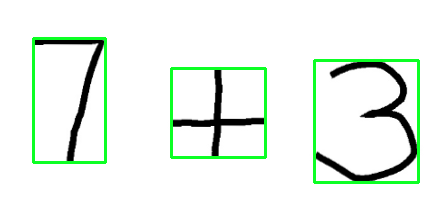

-1

In [203]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
os.mkdir("/content/drive/My Drive/Digits/Contours")
# Load image, grayscale, Otsu's threshold 
image = cv2.imread('/content/1_03Z5ZkOJ_r4kwr6Cy3FhKQ.png')
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Find contours, obtain bounding box, extract and save ROI
ROI_number = 0
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts2=order(cnts)

for c in cnts2:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    ROI = original[y:y+h, x:x+w]
    cv2.imwrite(("/content/drive/My Drive/Digits/Contours/"+"ROI_{}.png").format(ROI_number), ROI)
    
    ROI_number += 1

cv2_imshow(image)
cv2.waitKey()

In [204]:
from PIL import Image
import matplotlib.pyplot as plt

In [205]:
model,_,_=load_checkpoint('/content/drive/My Drive/Digits/resnet18.pth',model)

In [206]:
def process_image(image):
    
    pil_image = Image.open(image)
   
    image_transforms = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img = image_transforms(pil_image)
    return img

In [207]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    image = image.transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [208]:

def predict(image_path, model, topk=5):

    model.eval()
    model.cpu()
    img = process_image(image_path)
    x=img
    img = img.unsqueeze_(0)
    img = img.float()
    
    with torch.no_grad():
      last,output=model.forward(img)
      output=torch.exp(output)
      top_p,top_class=output.topk(1,dim=1)
      

        
    print('Top Classes: ', top_class)
    print('Top Probs: ', top_p)
    return top_p, top_class,x
    

In [209]:
def value(classes):
  classes=classes.tolist()
  x=classes[0][0]
  
  if(x==0):
    ans="!"
  if(x==1):
    ans="("
  if(x==2):
    ans=")"
  if(x==3):
    ans="+"
  if(x==4):
    ans="-"
  if(x==5):
    ans="0"
  if(x==6):
    ans="1"
  if(x==7):
    ans="2"
  if(x==8):
    ans="3"
  if(x==9):
    ans="4"
  if(x==10):
    ans="5"
  if(x==11):
    ans="6"
  if(x==12):
    ans="7"
  if(x==13):
    ans="8"
  if(x==14):
    ans="9"
  if(x==16):
    ans="/"
  if(x==18):
    ans="3.14"
  if(x==24):
    ans="*"

  return ans

Top Classes:  tensor([[12]])
Top Probs:  tensor([[0.3670]])
Top Classes:  tensor([[3]])
Top Probs:  tensor([[1.0000]])
Top Classes:  tensor([[8]])
Top Probs:  tensor([[0.9702]])


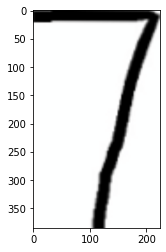

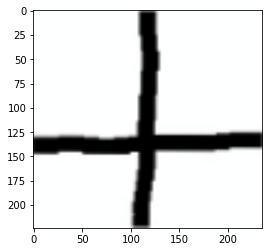

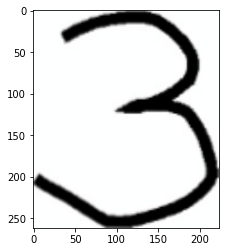

In [210]:
imgs=os.listdir("/content/drive/My Drive/Digits/Contours")
result=""
for i in imgs:
  image_path = ("/content/drive/My Drive/Digits/Contours/"+str(i))
  processed_image = process_image(image_path)
  processed_image=processed_image.numpy()
  imshow(processed_image)
  probs, classes,x = predict(image_path, model)
  img_class=value(classes)
  result+=img_class

In [211]:
result

'7+3'

In [212]:
eval(result)

10

In [213]:
!rm -rf "/content/drive/My Drive/Digits/Contours"